In [1]:
import numpy as np
import pandas as pd
from sklearn.cross_decomposition import CCA
import matplotlib.pyplot as plt

# 소수를 e로 표현하지 않도록 하기
pd.options.display.float_format = "{:.5f}".format

In [2]:
lib_2007 = pd.read_csv("final_data/lib_2007.csv")
lib_2008 = pd.read_csv("final_data/lib_2008.csv")
lib_2009 = pd.read_csv("final_data/lib_2009.csv")
lib_2010 = pd.read_csv("final_data/lib_2010.csv")
lib_2011 = pd.read_csv("final_data/lib_2011.csv")
lib_2012 = pd.read_csv("final_data/lib_2012.csv")
lib_2013 = pd.read_csv("final_data/lib_2013.csv")
lib_2014 = pd.read_csv("final_data/lib_2014.csv")
lib_2015 = pd.read_csv("final_data/lib_2015.csv")
lib_2016 = pd.read_csv("final_data/lib_2016.csv")
lib_2017 = pd.read_csv("final_data/lib_2017.csv")
lib_2018 = pd.read_csv("final_data/lib_2018.csv")
lib_2019 = pd.read_csv("final_data/lib_2019.csv")
lib_2020 = pd.read_csv("final_data/lib_2020.csv")
lib_2021 = pd.read_csv("final_data/lib_2021.csv")

In [3]:
train_lib = pd.concat([lib_2007,lib_2008,lib_2009,lib_2010,lib_2011,lib_2012,lib_2013,lib_2014,lib_2015,lib_2016,lib_2017])
valid_lib = pd.concat([lib_2018, lib_2019])
test_lib = pd.concat([lib_2020,lib_2021])

In [4]:
# 이상치 제거 전 train, test set의 데이터 수 구하기
print(f"이상치 제거 전 train set의 데이터 수 : {len(train_lib)}")
print(f"이상치 제거 전 valid set의 데이터 수 : {len(valid_lib)}")
print(f"이상치 제거 전 test set의 데이터 수 : {len(test_lib)}")

이상치 제거 전 train set의 데이터 수 : 9026
이상치 제거 전 valid set의 데이터 수 : 2222
이상치 제거 전 test set의 데이터 수 : 2370


In [5]:
# 사분위수를 활용하여 비율 충족도의 이상치 행 제거하기
def del_outlier(df, col):
    q1 = df[col].quantile(0.10)
    q3 = df[col].quantile(0.90)
    iqr = q3 - q1 
    boundary = 1.5 * iqr 

    upper_index = df[df[col] > q3 + boundary].index
    lower_index = df[df[col] < q1 - boundary].index 

    df.drop(upper_index, inplace = True)
    df.drop(lower_index, inplace = True)

    return df

del_outlier(train_lib, "future_acq_budget_settlement")
del_outlier(valid_lib, "future_acq_budget_settlement")
del_outlier(test_lib, "future_acq_budget_settlement") 

# 이상치 제거 후 train, test set의 데이터 수 구하기
print(f"이상치 제거 후 train set의 데이터 수 : {len(train_lib)}")
print(f"이상치 제거 후 valid set의 데이터 수 : {len(valid_lib)}")
print(f"이상치 제거 후 test set의 데이터 수 : {len(test_lib)}")

이상치 제거 후 train set의 데이터 수 : 8184
이상치 제거 후 valid set의 데이터 수 : 2178
이상치 제거 후 test set의 데이터 수 : 2310


In [6]:
from sklearn.preprocessing import MinMaxScaler

# Min-Max Scaler 생성
scaler = MinMaxScaler()

# 모든 변수에 대해 Min-Max Scaling 적용
# 스케일러를 학습 데이터에 대해 fit
scaler.fit(train_lib.drop(columns=["future_acq_budget_settlement"]))

# 학습 데이터에 대해 변환
train_lib_scaled = pd.DataFrame(scaler.transform(train_lib.drop(columns=["future_acq_budget_settlement"])), 
                                columns=train_lib.columns[:-1])

# 타겟 변수에 대해 스케일링 적용
scaler_y = MinMaxScaler()
train_y_scaled = scaler_y.fit_transform(train_lib[['future_acq_budget_settlement']])

# 학습 데이터에 스케일된 타겟 변수 추가
train_lib_scaled['future_acq_budget_settlement_scaled'] = train_y_scaled

# 검증 데이터에 대해 변환
valid_lib_scaled = pd.DataFrame(scaler.transform(valid_lib.drop(columns=["future_acq_budget_settlement"])), 
                                columns=train_lib.columns[:-1])
valid_y_scaled = scaler_y.transform(valid_lib[['future_acq_budget_settlement']])
valid_lib_scaled['future_acq_budget_settlement_scaled'] = valid_y_scaled

# 테스트 데이터에 대해 변환
test_lib_scaled = pd.DataFrame(scaler.transform(test_lib.drop(columns=["future_acq_budget_settlement"])), 
                               columns=train_lib.columns[:-1])
test_y_scaled = scaler_y.transform(test_lib[['future_acq_budget_settlement']])
test_lib_scaled['future_acq_budget_settlement_scaled'] = test_y_scaled

# X_train, Y_train 구성하기 (스케일된 타겟 사용)
X_train = train_lib_scaled.drop(columns=["future_acq_budget_settlement_scaled"])
Y_train = train_lib_scaled["future_acq_budget_settlement_scaled"]

# X_valid, Y_valid 구성하기 (스케일된 타겟 사용)
X_valid = valid_lib_scaled.drop(columns=["future_acq_budget_settlement_scaled"])
Y_valid = valid_lib_scaled["future_acq_budget_settlement_scaled"]

# X_test, Y_test 구성하기 (스케일된 타겟 사용)
X_test = test_lib_scaled.drop(columns=["future_acq_budget_settlement_scaled"])
Y_test = test_lib_scaled["future_acq_budget_settlement_scaled"]


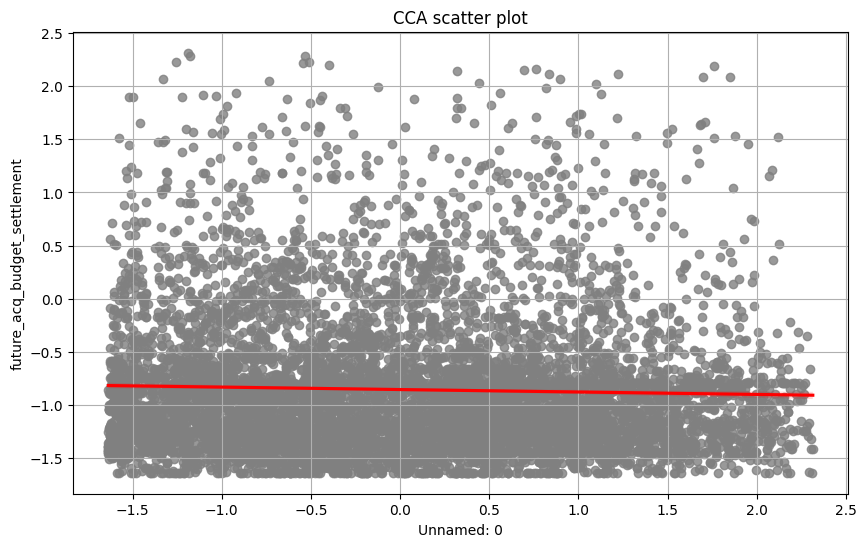

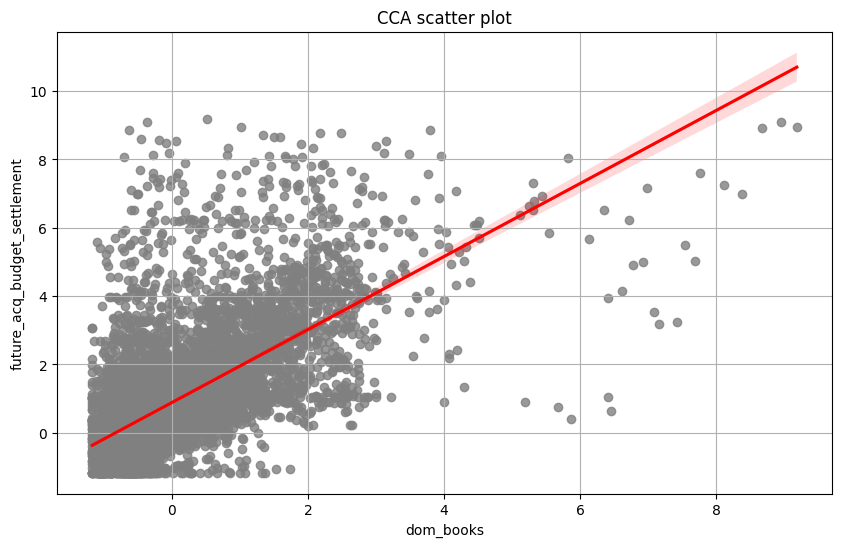

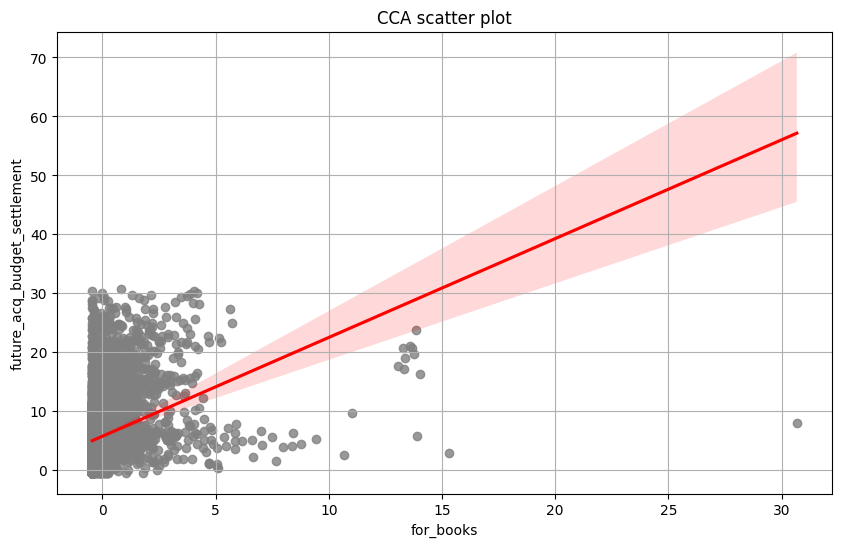

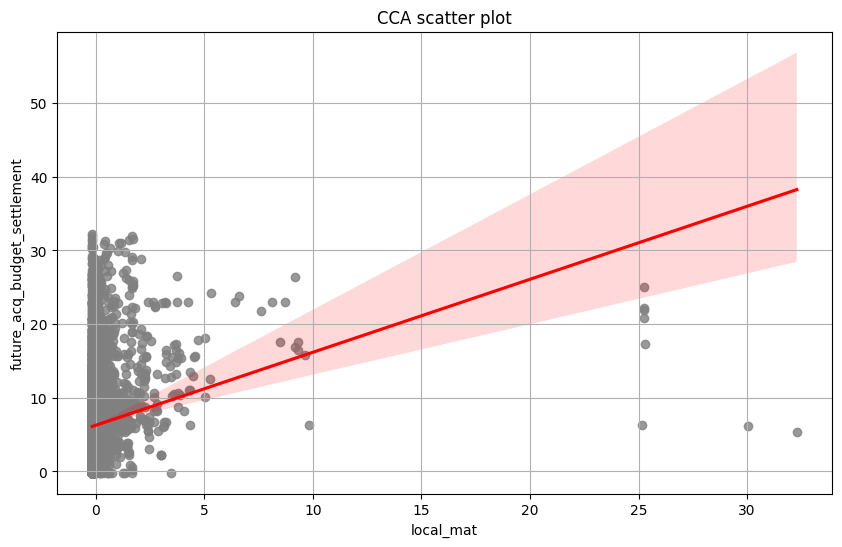

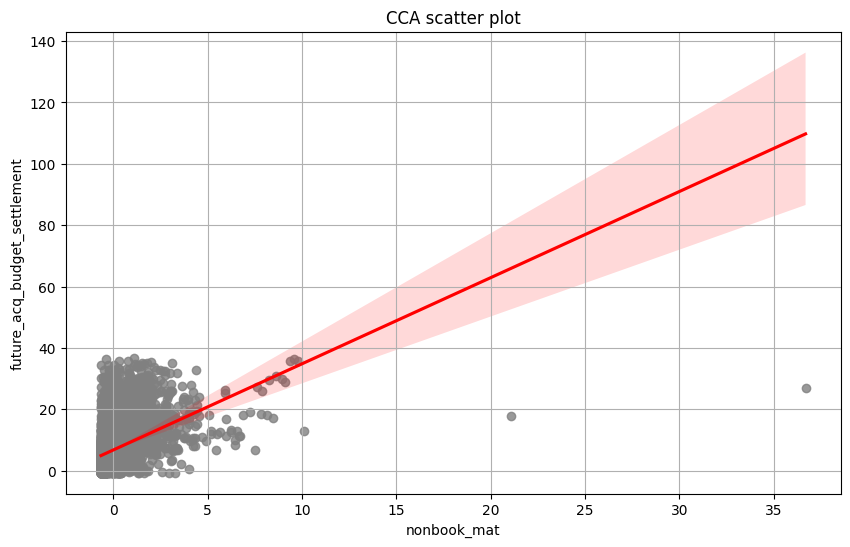

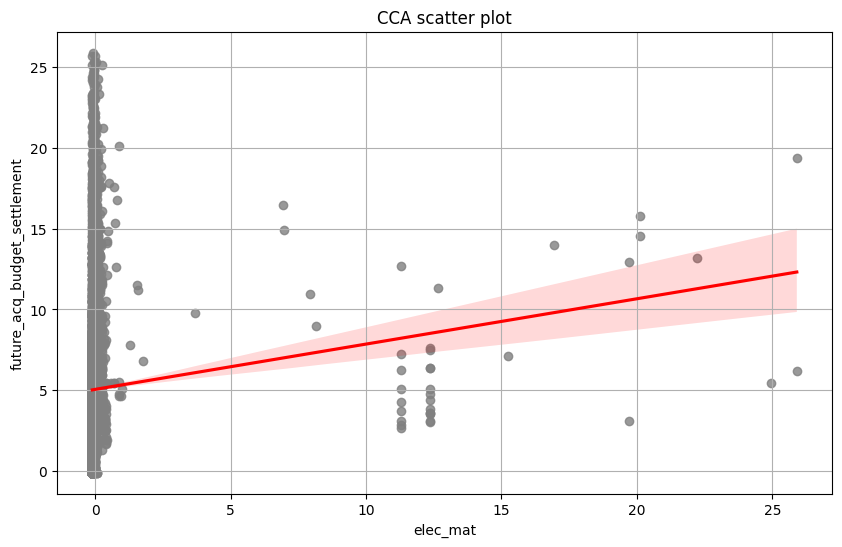

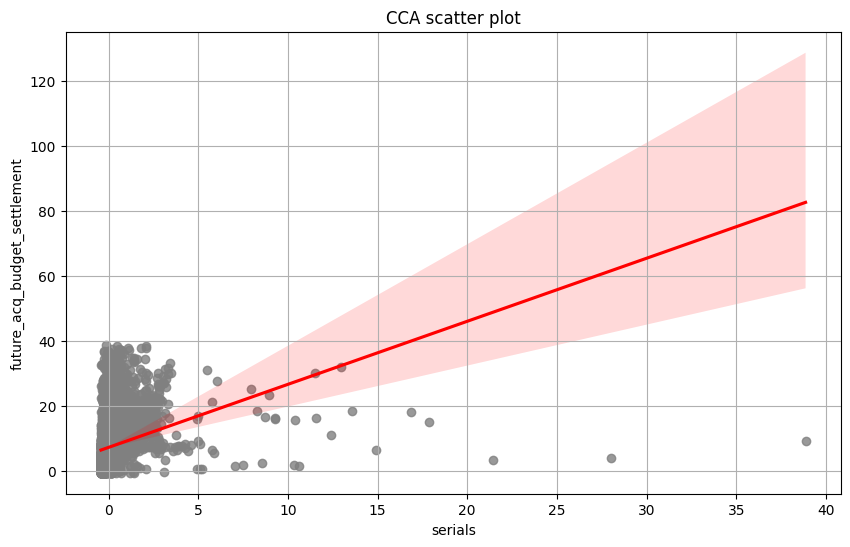

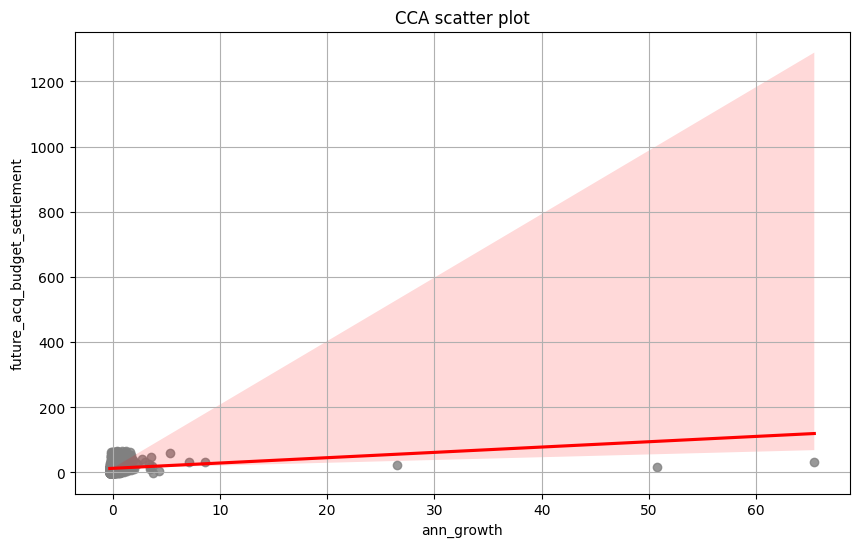

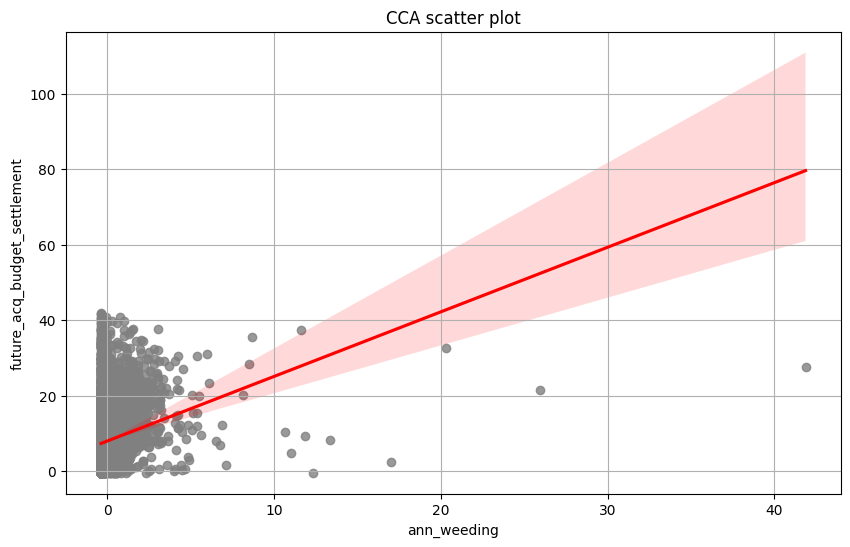

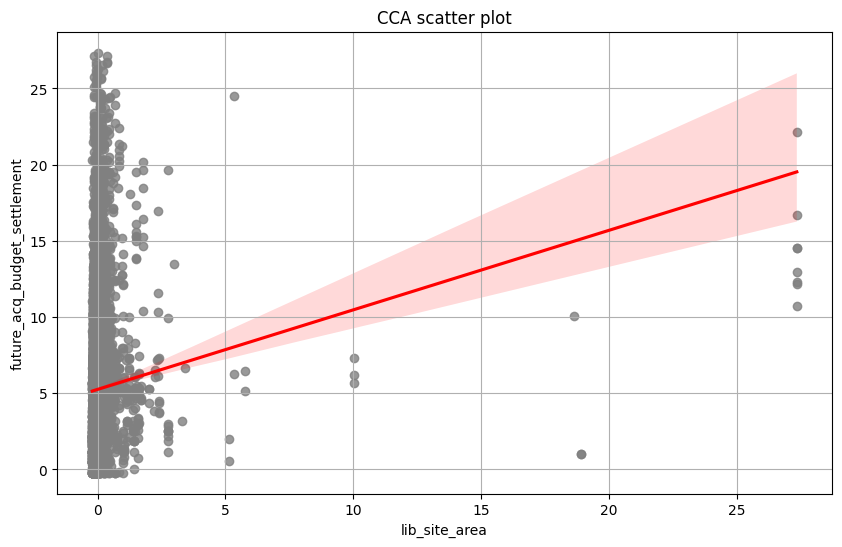

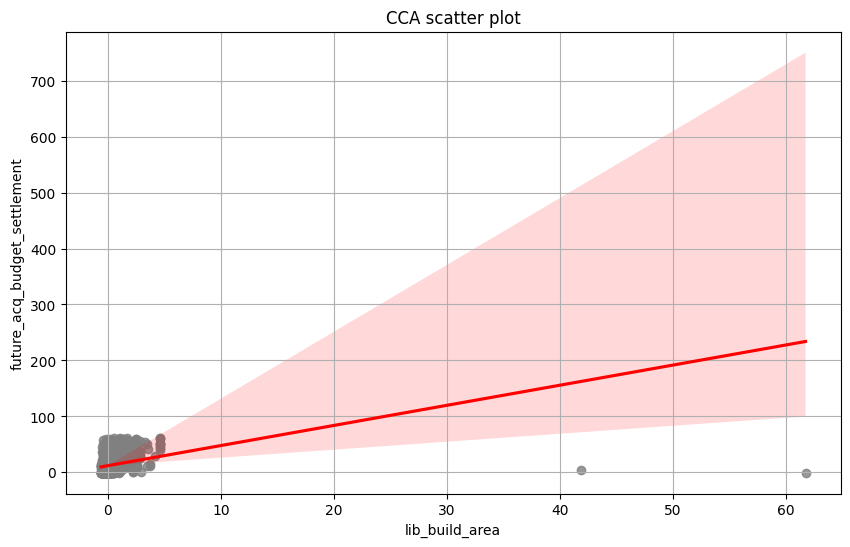

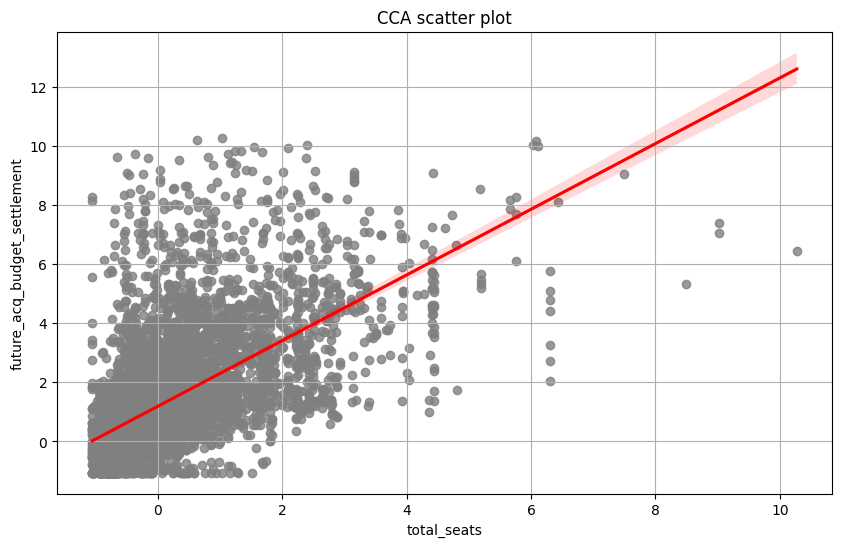

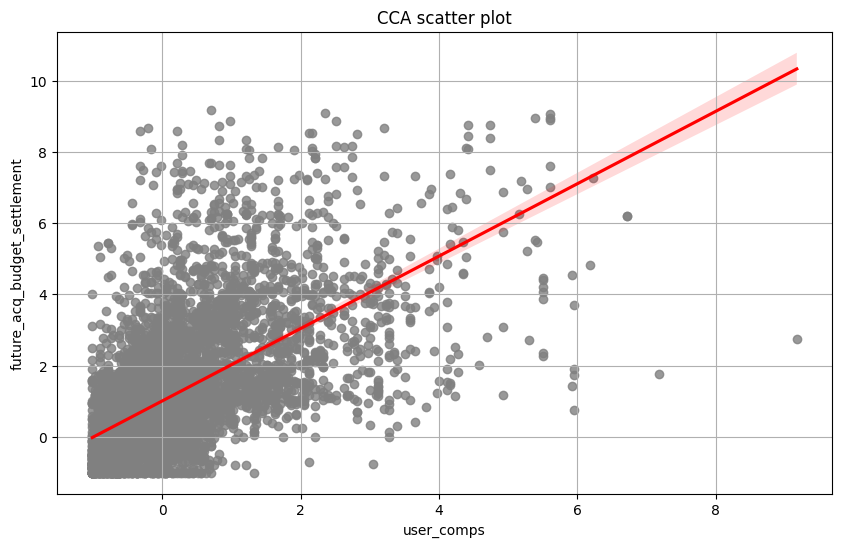

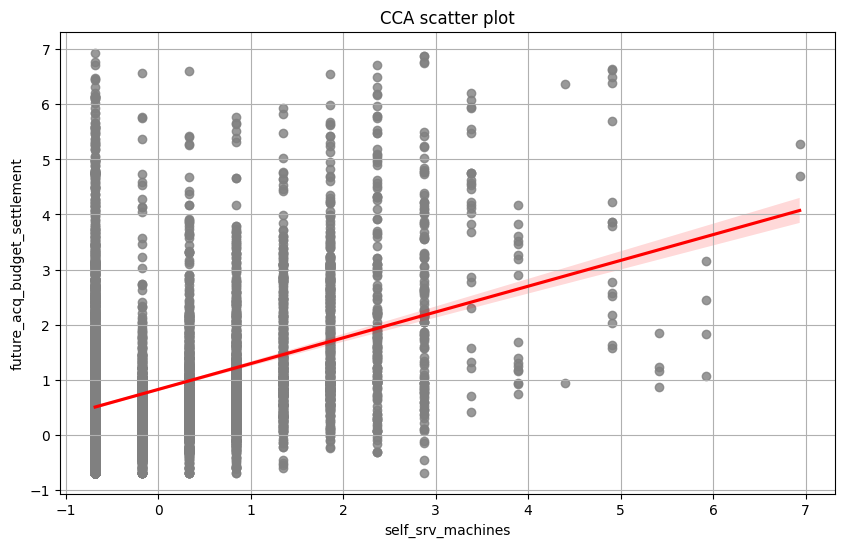

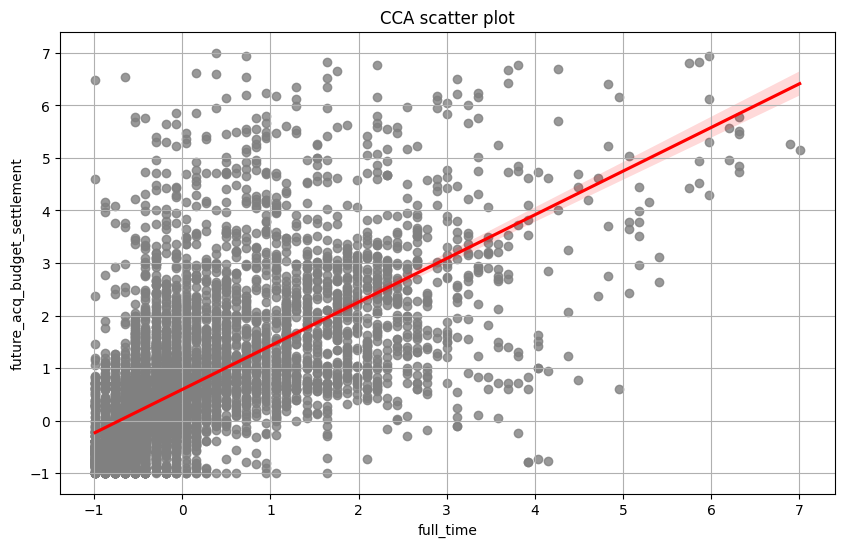

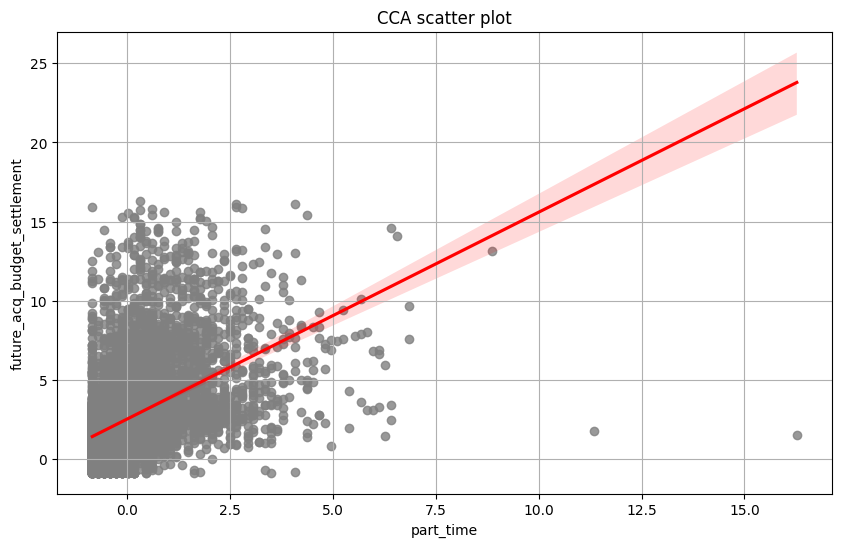

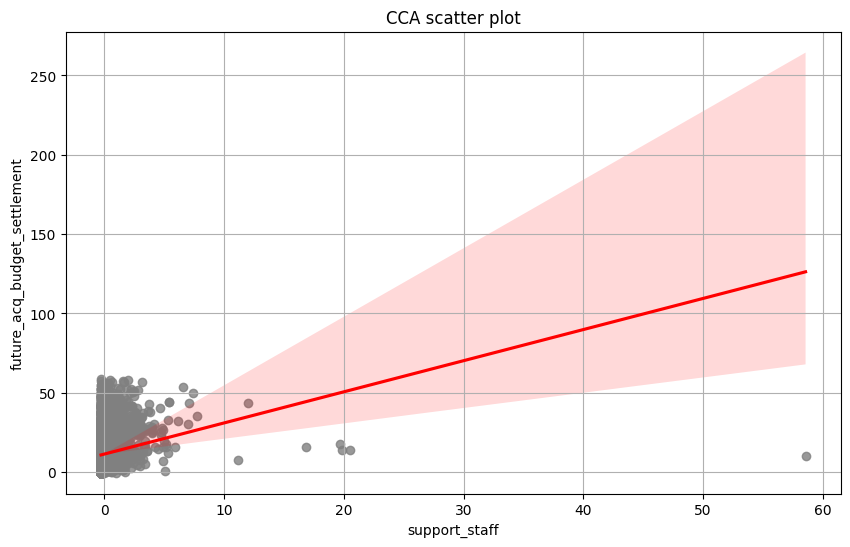

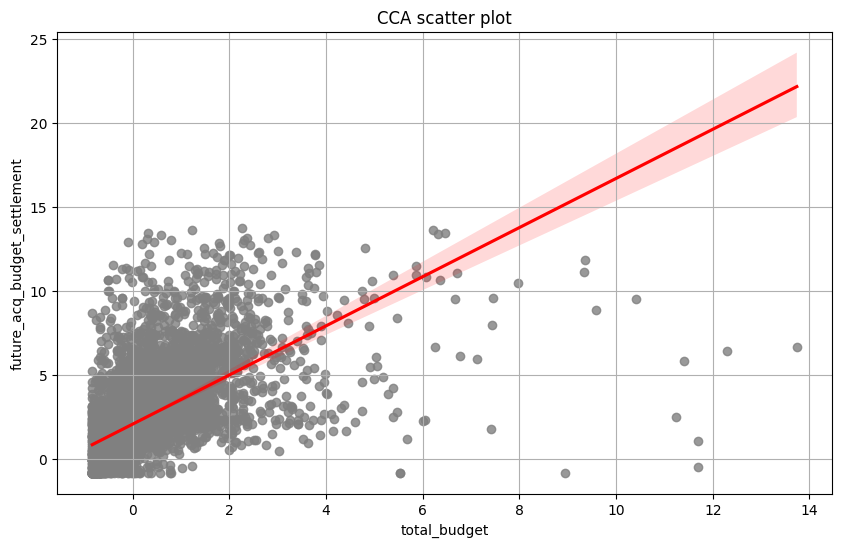

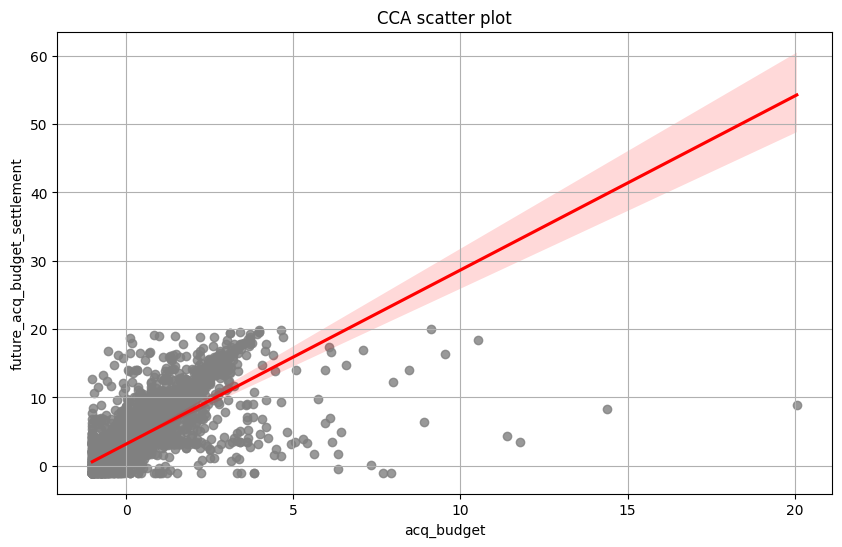

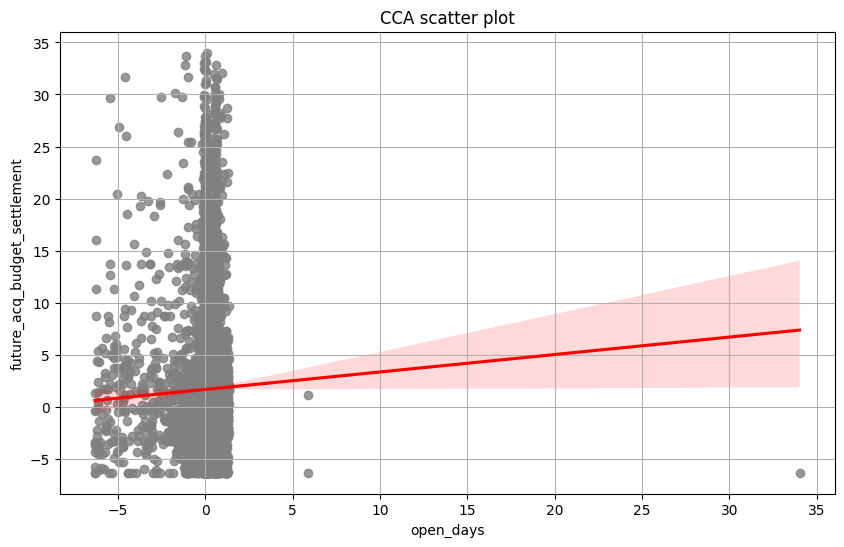

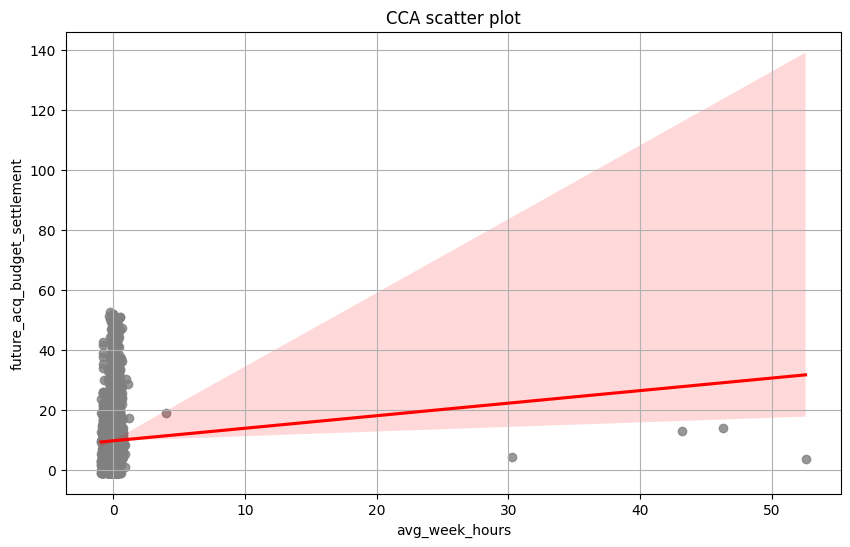

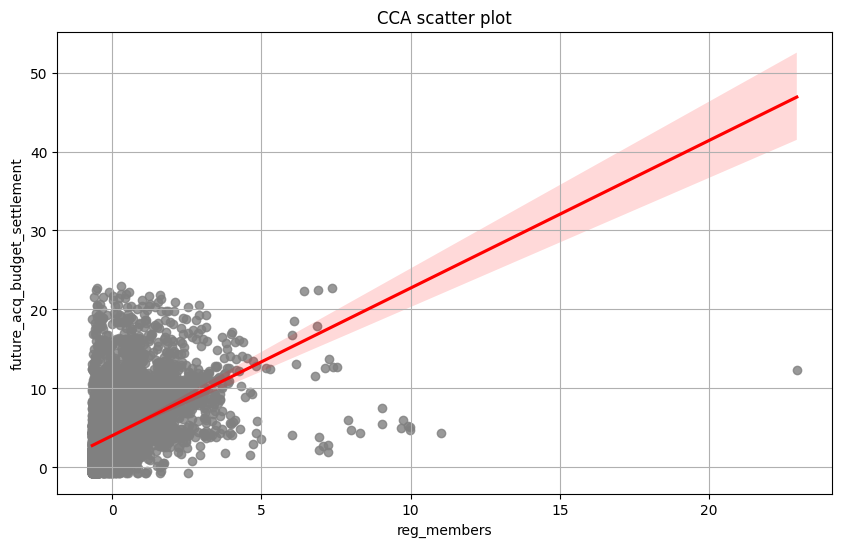

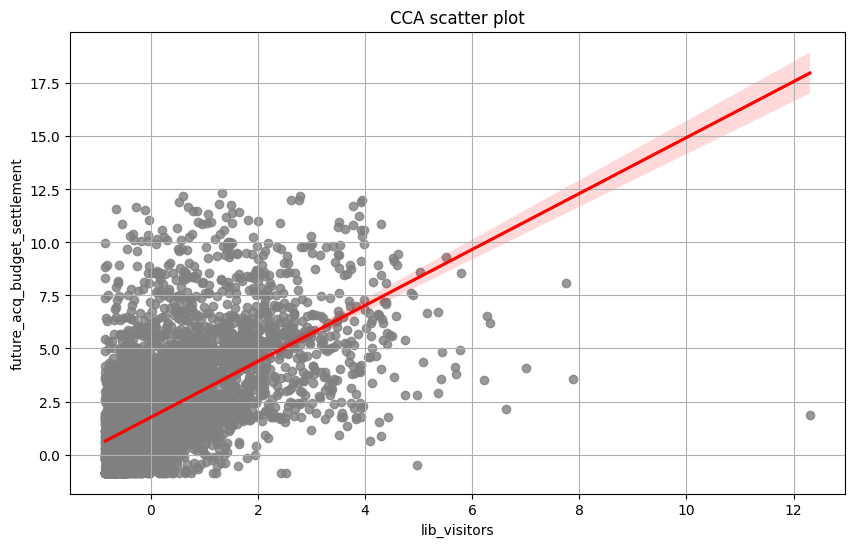

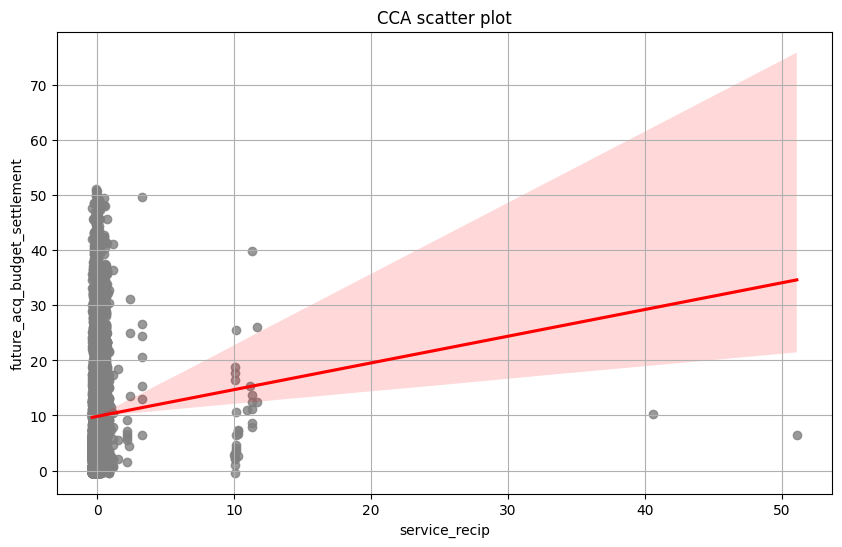

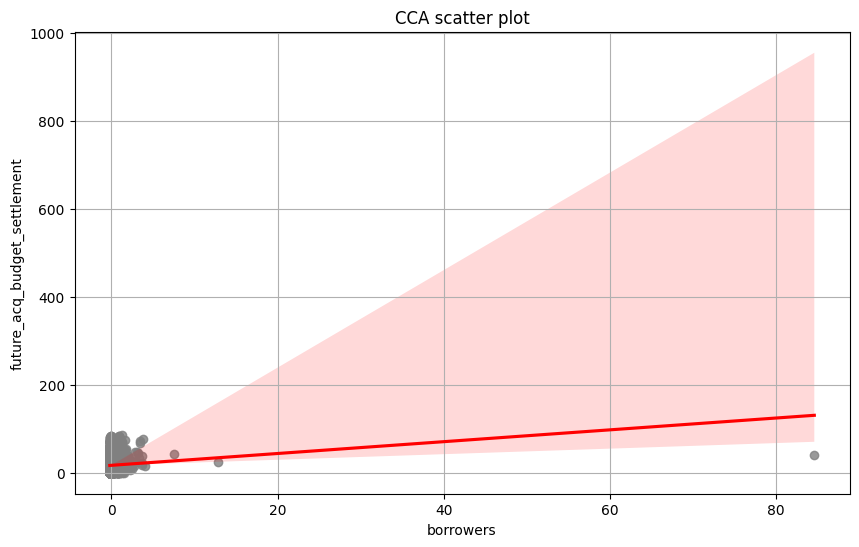

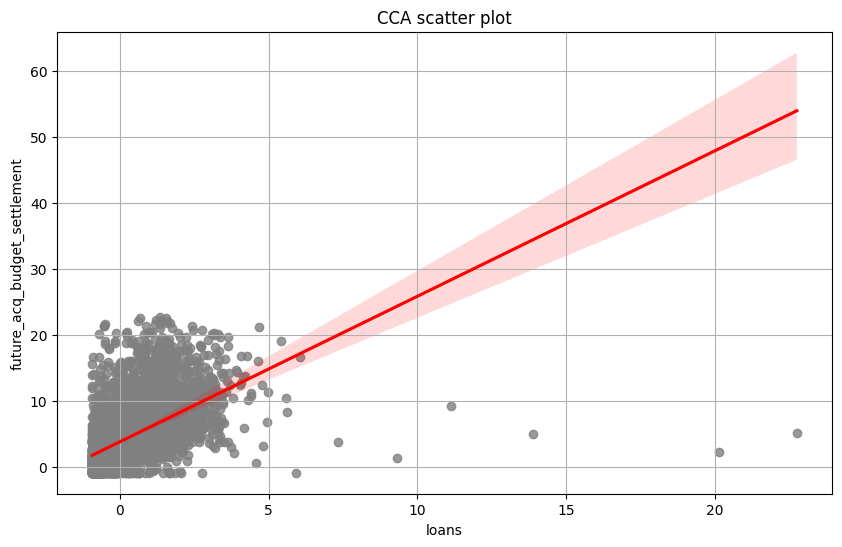

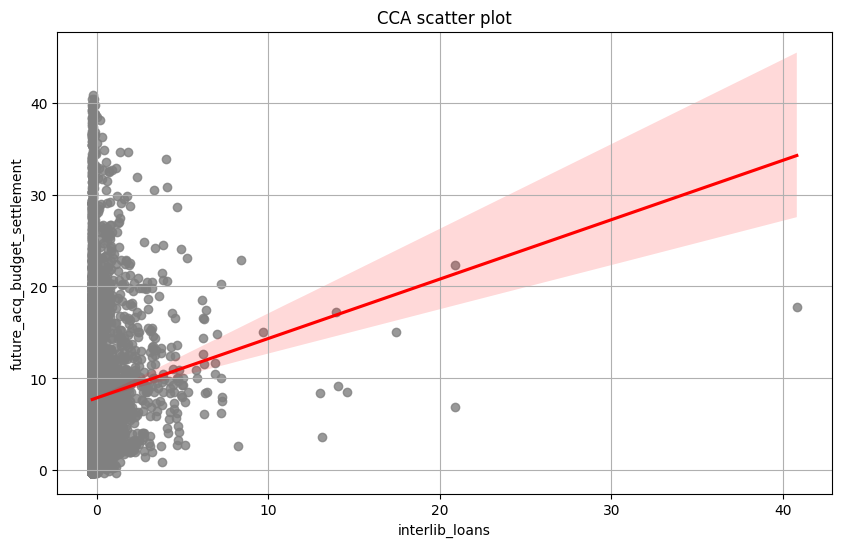

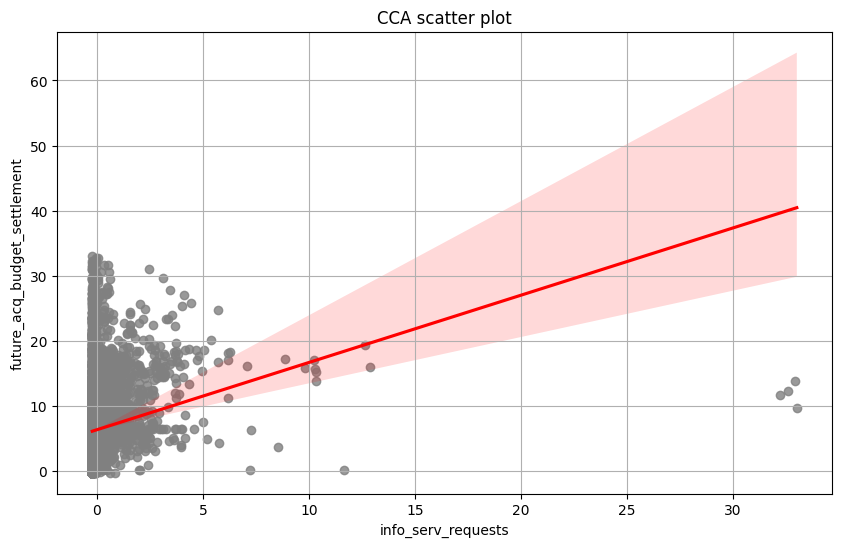

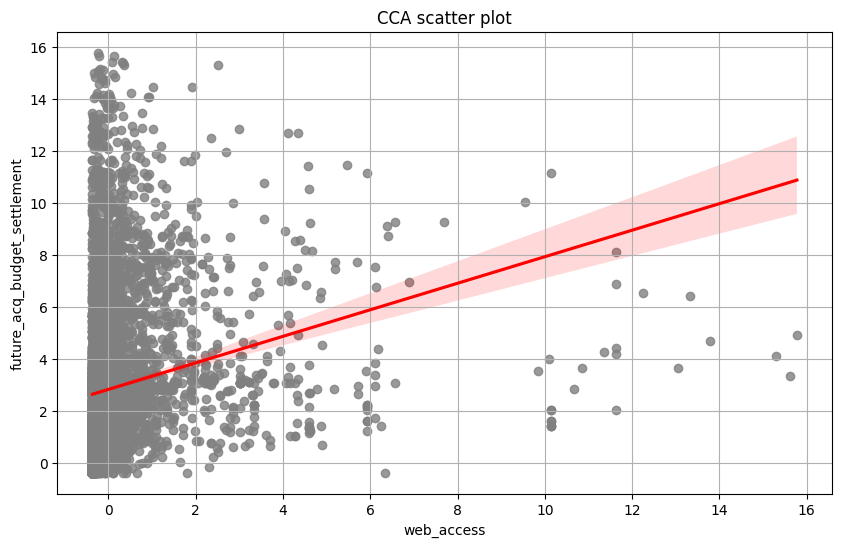

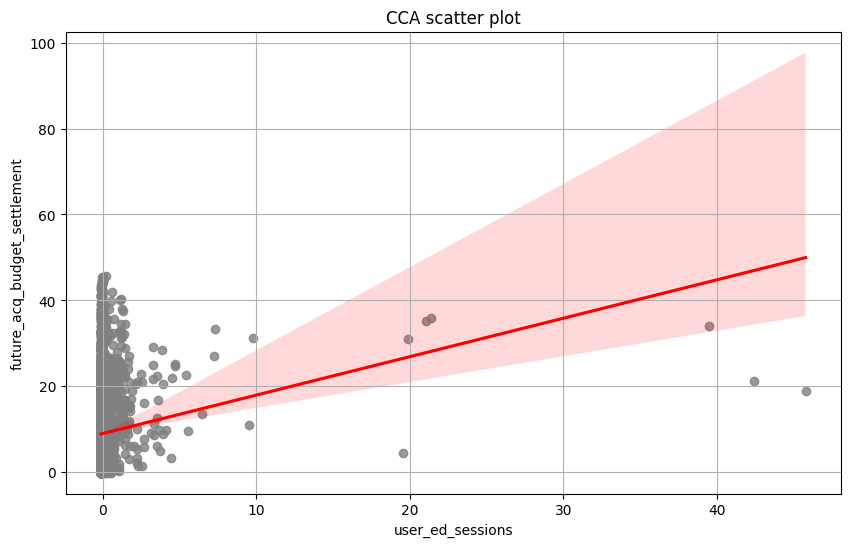

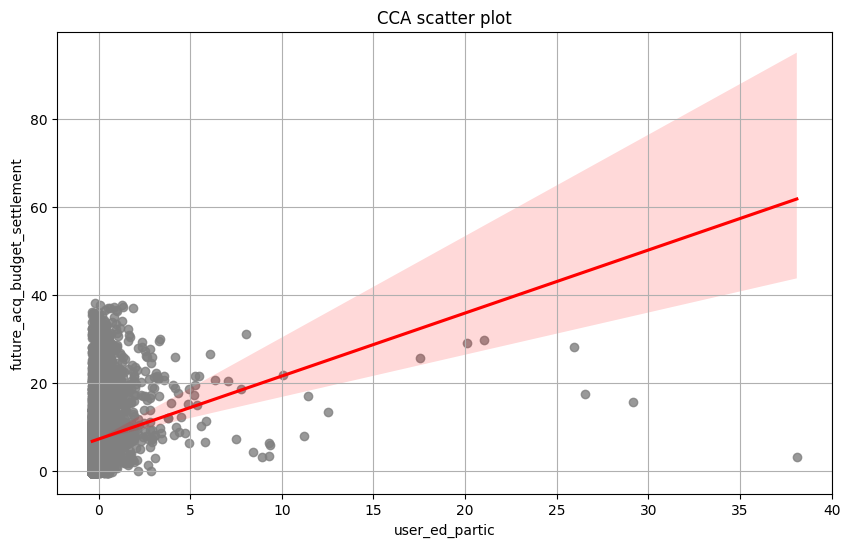

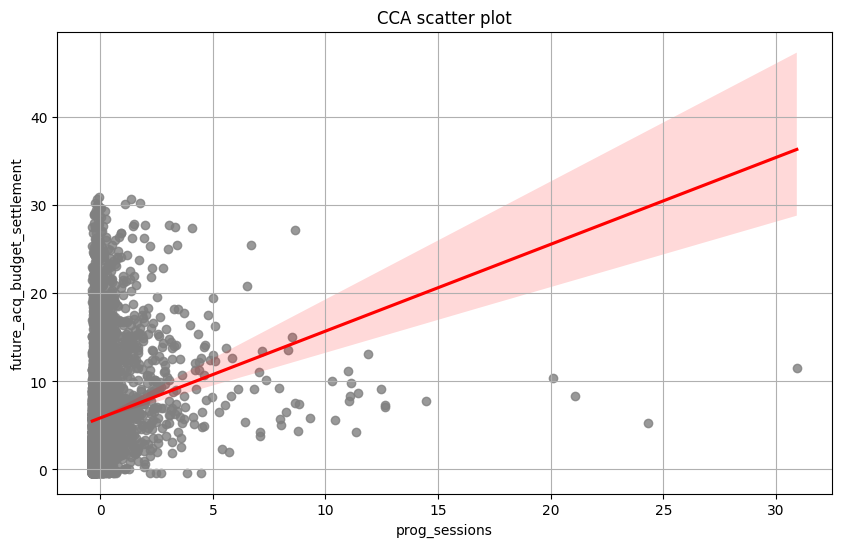

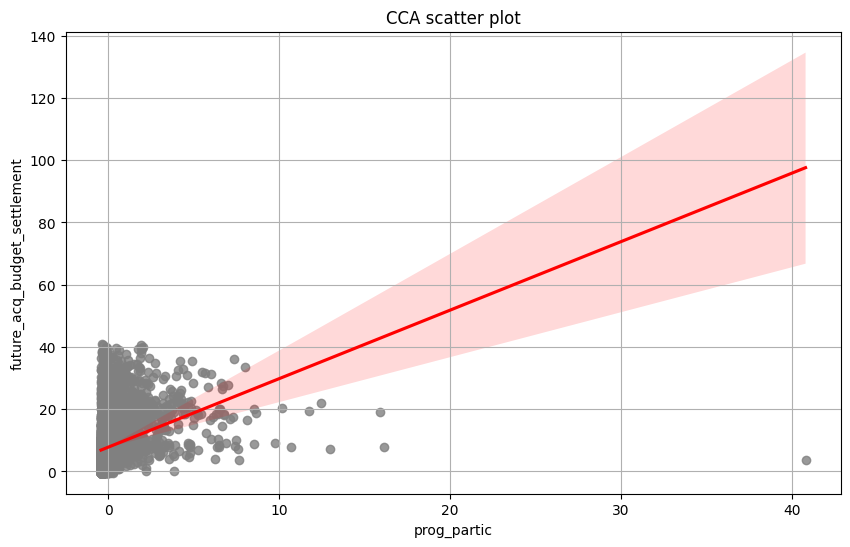

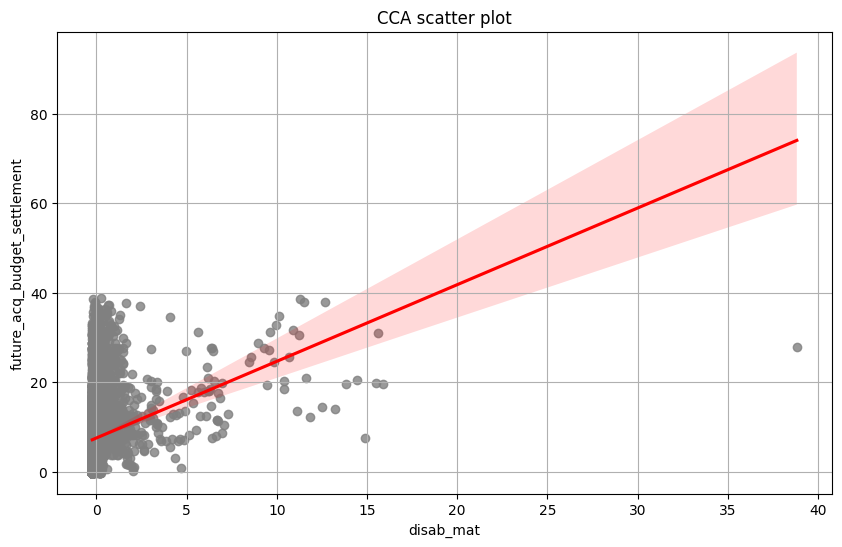

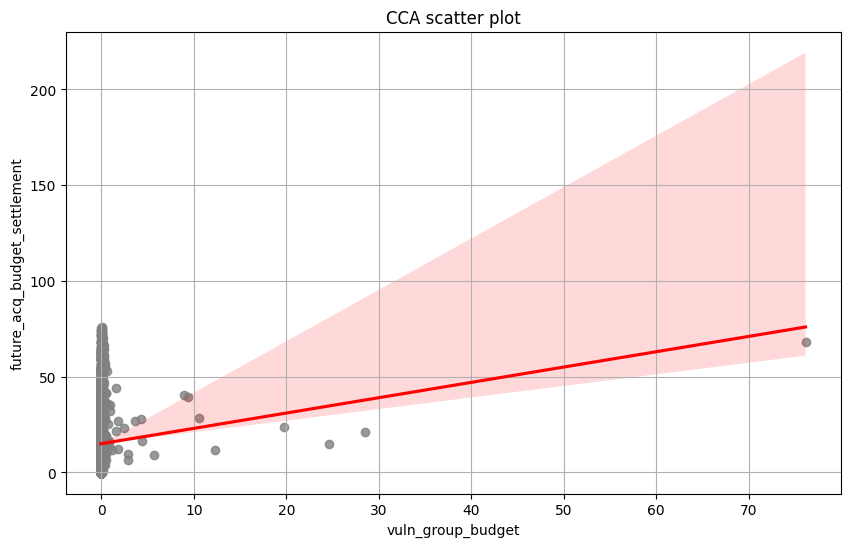

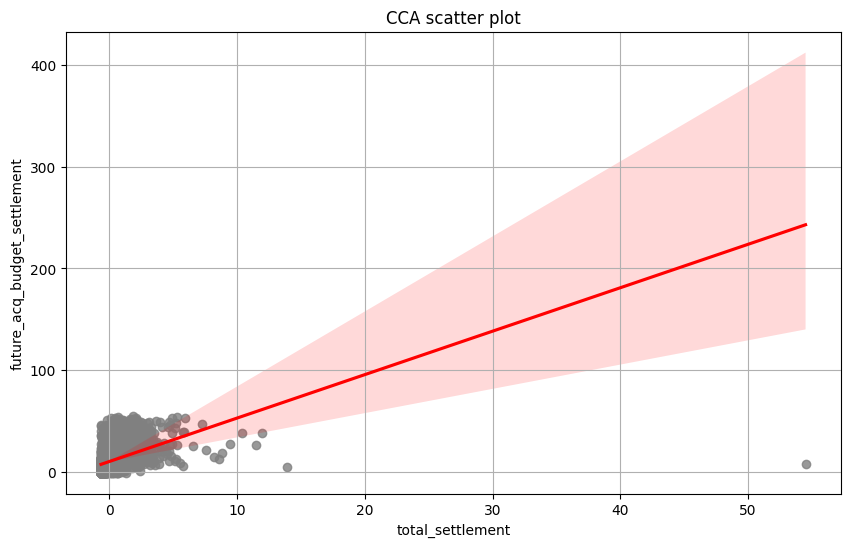

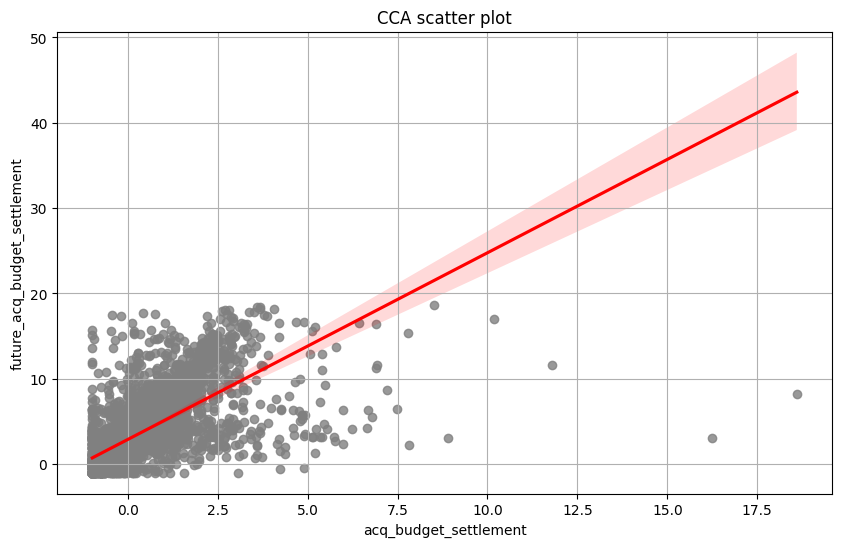

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cross_decomposition import CCA

column_names = X_train.columns

# CCA 수행
cca_results = []
for i in range(X_train.shape[1]):
    cca = CCA(n_components=1)
    cca.fit(X_train.iloc[:, i].values.reshape(-1, 1), Y_train.values.reshape(-1, 1))
    cca_results.append(cca)

# 각 독립변수에 대한 CCA 결과 시각화 및 회귀선 추가
for i, cca in enumerate(cca_results):
    # 독립변수와 종속변수 데이터 준비
    X_variable = X_train.iloc[:, i].values
    Y_variable = Y_train.values.flatten()
    
    # CCA를 사용하여 독립변수와 종속변수의 선형 조합 계산
    X_transformed = cca.transform(X_variable.reshape(-1, 1))
    Y_transformed = cca.transform(Y_variable.reshape(-1, 1))

    # 회귀선 플롯
    plt.figure(figsize=(10, 6))
    sns.regplot(x=X_transformed.flatten(), y=Y_transformed.flatten(), line_kws={'color': 'red'}, color='gray')
    plt.title(f'CCA scatter plot')
    plt.xlabel(f'{X_train.columns[i]}')
    plt.ylabel('future_acq_budget_settlement')
    plt.grid(True)
    plt.show()
